In [9]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from LDS import gLDS
import pandas as pd
from util import plotting
% matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
from util import data
data_dir = "../data/raw/DualALMRecordinbgsDataSet2018_04_14"
all_sessions = data.PerturbationData(data_dir)

# for now, we're only looking at a single session
SESSION_ID = 0
session = all_sessions.sessions[SESSION_ID]

Filtering 34 trials


In [3]:
recording_region = []
for n in range(session['neurons'].shape[1]):
    recording_region.append(session['neurons'][0,n][1][0][0][0][2][0])
recording_region = np.array(recording_region)[session['spike_filter']]

In [6]:
spikes = session['spikes'] # get raw spike raster for delay period (sparse format)
smooth_spikes = data.naive_smooth(spikes.todense(),400,20) # get firing rates
d_obs = smooth_spikes.shape[0] # observed data dimension
d_latent = 10 # hyper parameter, size of the latent state
T = smooth_spikes.shape[2] # number of timesteps

In [7]:
# get unperturbed trials
no_stim_inds = session['task_stimulation'][:,0] == 0
spikes = smooth_spikes[:,no_stim_inds]
spikes = spikes.transpose((2,1,0)) # LDS code expects (T, N, D)

## Fit and evaluate LDS model

In [12]:
model = gLDS()
x_hat, ll = model.fit(spikes, d_latent)

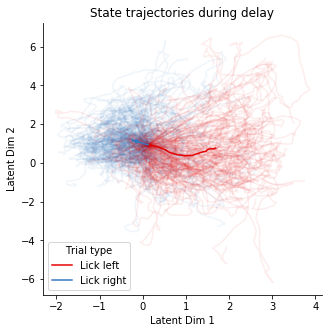

In [13]:
lick_left_states = x_hat[:, session['task_trial_type'][no_stim_inds] == 'l']
lick_right_states = x_hat[:, session['task_trial_type'][no_stim_inds] == 'r']
fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = plotting.xkcd_colors()
for i in range(lick_right_states.shape[1]):
    ax.plot(lick_right_states[:,i,0], lick_right_states[:,i,1], alpha=.07, color=colors[0]) 

for i in range(lick_left_states.shape[1]):
    ax.plot(lick_left_states[:,i,0], lick_left_states[:,i,1], alpha=.07, color=colors[1]) 

ax.plot(np.mean(lick_left_states, axis = 1)[:,0],np.mean(lick_left_states, axis = 1)[:,1], color=colors[1],label='Lick left')
ax.plot(np.mean(lick_right_states, axis = 1)[:,0],np.mean(lick_right_states, axis = 1)[:,1],color=colors[0],label='Lick right')

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('State trajectories during delay')
ax.legend()
ax.legend_.set_title('Trial type')
plotting.remove_frame(ax)
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# separate hemispheres

## left

In [14]:
model = gLDS()
x_hat, ll = model.fit(spikes[:,:,recording_region=='left_ALM'], d_latent)

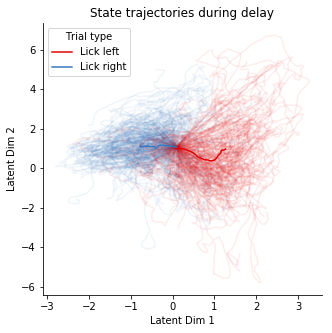

In [15]:
lick_left_states = x_hat[:, session['task_trial_type'][no_stim_inds] == 'l']
lick_right_states = x_hat[:, session['task_trial_type'][no_stim_inds] == 'r']
fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = plotting.xkcd_colors()
for i in range(lick_right_states.shape[1]):
    ax.plot(lick_right_states[:,i,0], lick_right_states[:,i,1], alpha=.07, color=colors[0]) 

for i in range(lick_left_states.shape[1]):
    ax.plot(lick_left_states[:,i,0], lick_left_states[:,i,1], alpha=.07, color=colors[1]) 

ax.plot(np.mean(lick_left_states, axis = 1)[:,0],np.mean(lick_left_states, axis = 1)[:,1], color=colors[1],label='Lick left')
ax.plot(np.mean(lick_right_states, axis = 1)[:,0],np.mean(lick_right_states, axis = 1)[:,1],color=colors[0],label='Lick right')

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('State trajectories during delay')
ax.legend()
ax.legend_.set_title('Trial type')
plotting.remove_frame(ax)
xlims = ax.get_xlim()
ylims = ax.get_ylim()

## right

In [16]:
model = gLDS()
x_hat, ll = model.fit(spikes[:,:,recording_region=='right_ALM'], d_latent)

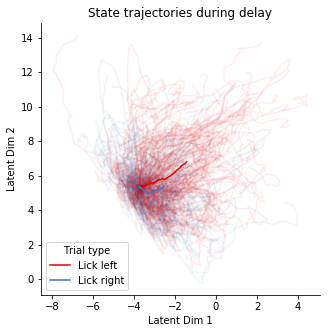

In [17]:
lick_left_states = x_hat[:, session['task_trial_type'][no_stim_inds] == 'l']
lick_right_states = x_hat[:, session['task_trial_type'][no_stim_inds] == 'r']
fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = plotting.xkcd_colors()
for i in range(lick_right_states.shape[1]):
    ax.plot(lick_right_states[:,i,0], lick_right_states[:,i,1], alpha=.07, color=colors[0]) 

for i in range(lick_left_states.shape[1]):
    ax.plot(lick_left_states[:,i,0], lick_left_states[:,i,1], alpha=.07, color=colors[1]) 

ax.plot(np.mean(lick_left_states, axis = 1)[:,0],np.mean(lick_left_states, axis = 1)[:,1], color=colors[1],label='Lick left')
ax.plot(np.mean(lick_right_states, axis = 1)[:,0],np.mean(lick_right_states, axis = 1)[:,1],color=colors[0],label='Lick right')

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('State trajectories during delay')
ax.legend()
ax.legend_.set_title('Trial type')
plotting.remove_frame(ax)
xlims = ax.get_xlim()
ylims = ax.get_ylim()

## metrics of fit

Variance explained on held out neurons/trials

In [21]:
model_explained_variances, psth_explained_variances = lds.kfold_cross_val(spikes, 10, session['task_trial_type'][no_stim_inds])

Fold 1 of 3
Fold 2 of 3
Fold 3 of 3


Text(0.5, 1.0, 'LDS v.s. per-contigency trial average')

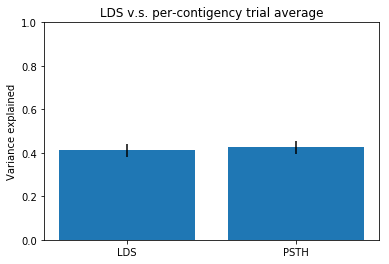

In [34]:
fig, ax = plt.subplots(1,1)
from matplotlib.ticker import FuncFormatter

ind = np.arange(2)
heights = [np.mean(model_explained_variances), np.mean(psth_explained_variances)]
errors = [np.std(model_explained_variances), np.std(psth_explained_variances)]

ax.bar(ind, height = heights, yerr = errors)
ax.set_xticks(ind)
ax.set_xticklabels(['LDS', 'PSTH'])
ax.set_ylim([0,1])
ax.set_ylabel('Variance explained')
ax.set_title('LDS v.s. per-contigency trial average')

so using LDS doesn't buy us much on this dataset -- it does no better than the trial average at predicting single trials.

# animated state trajectories
generate an animation of the latent trajectories over time; animation is only viewable in the mp4 output.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots()
# use xlim/ylim from plot with all the data
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ims = []
for t in range(T):

    frame_lines = []
    for i in range(lick_right_states.shape[1]):
        l, = ax.plot(lick_right_states[:t,i,0], lick_right_states[:t,i,1], alpha=.07, color=colors[0])
        frame_lines.append(l)
    for i in range(lick_left_states.shape[1]):
        l, = ax.plot(lick_left_states[:t,i,0], lick_left_states[:t,i,1], alpha=.07, color=colors[1])
        frame_lines.append(l)
    right_mean, = ax.plot(np.mean(lick_right_states, axis = 1)[:t,0],np.mean(lick_right_states, axis = 1)[:t,1],color=colors[0])
    left_mean, = ax.plot(np.mean(lick_left_states, axis = 1)[:t,0],np.mean(lick_left_states, axis = 1)[:t,1],color=colors[1])
    frame_lines.append(right_mean)
    frame_lines.append(left_mean)
    ims.append(frame_lines)
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
# ani.save("{} unperturbed latent trajectories.mp4".format(filename), dpi=400,writer='ffmpeg')